In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6', 'densenet']


In [2]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [3]:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [5]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

In [6]:
densenet = DenseNet121(
    weights='../input/densenet/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(32,32,3)
)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(14, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [9]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=7,
    callbacks=[checkpoint, f1_metrics],
    validation_split=0.1
)

Instructions for updating:
Use tf.cast instead.
Train on 176669 samples, validate on 19630 samples
Epoch 1/7
176669/176669 [==============================] - 4175s 24ms/step - loss: 0.5611 - acc: 0.8210 - val_loss: 0.4383 - val_acc: 0.8596

Epoch 00001: val_acc improved from -inf to 0.85955, saving model to model.h5


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val_f1: 0.5717 — val_precision: 0.5981 — val_recall: 0.5704
Epoch 2/7
176669/176669 [==============================] - 4000s 23ms/step - loss: 0.3818 - acc: 0.8746 - val_loss: 0.3181 - val_acc: 0.8941

Epoch 00002: val_acc improved from 0.85955 to 0.89414, saving model to model.h5
val_f1: 0.7237 — val_precision: 0.7686 — val_recall: 0.7048
Epoch 3/7
 27968/176669 [===>..........................] - ETA: 54:58 - loss: 0.2949 - acc: 0.9023

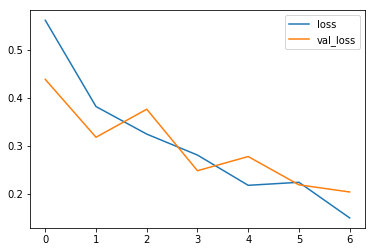

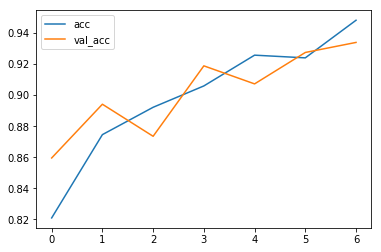

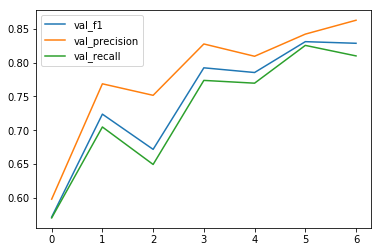

In [10]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

In [11]:
model.load_weights('model.h5')
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)

In [12]:
submission_df.to_csv('submission.csv',index=False)
submission_df.head(15)

,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,1
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,9
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,9
5,8784ac8a-2c1f-11e9-bcad-06f10d5896c4,11
6,4808497d-2c1a-11e9-bcad-06f10d5896c4,9
7,1f21b58a-2c09-11e9-bcad-06f10d5896c4,1
8,69fea4d2-2c04-11e9-bcad-06f10d5896c4,0
9,f8ff7f72-2c04-11e9-bcad-06f10d5896c4,6
